# PART 1: DIABETES CLASSIFICATION

In this project, I have chosen a dataset that classifies whether a patient has diabetes or not. The dataset can be downloaded from the following webpage: https://www.kaggle.com/datasets/mathchi/diabetes-data-set.


The Jupyter notebook consists of five main sections:
1. Process dataset
2. Train model
3. Evaluate model
4. Optimization
5. Show results

Before executing the Jupyter file, it is highly recommended to read the readme.md file for important instructions and guidelines.

### Imports & Enums

In [11]:
# Imports
import pickle
import itertools
import pandas as pd
import numpy as  np
import seaborn as sns
from enum import Enum
from sklearn.svm import SVC
from tabulate import tabulate
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from diabetes_constants import DATASET_CSV_FILE, BETA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler


# Enum definitions
class Model(Enum):
    """
    An enumeration of models.

    Each attribute represents a different model to be tested in the current project

    Attributes:
        LR: Logistic Regression.
        NB: Naive Bayes.
        KNN: K-Nearest Neighbors.
        SVM: Support Vector Machine.
    """
    LR = 1
    NB = 2
    KNN = 3
    SVM = 4


class ScalingMethods(Enum):
    """
    An enumeration of preprocessing scaling technologies.

    Each attribute represents a different scalinig technique.

    Attributes:
        StandardScaler: The Standard Scaler techinque
        MinMaxScaler: The MinMax Scaler techinque
        MaxAbsScaler: The MaxAbs Scaler techinque
        RobustScaler: The Robust Scaler techinque
    """
    StandardScaler = 1
    MinMaxScaler = 2
    MaxAbsScaler = 3
    RobustScaler = 4

### Process dataset
In this section, I load, scale, oversample, and split the dataset into three different sets: train (80%), test (20%), and validation (20%). I test several scaling methods, including StandardScaler, MinMaxScaler, MaxAbsScaler, and RobustScaler. To address the imbalanced dataset issue, I apply the oversampling technique using SMOTE.

Dataset information:
* Total samples: 768
* Training size: 460 samples (60% of the dataset)
* Testing size: 154 samples (20% of the dataset)
* Validation size: 154 samples (20% of the dataset)

In [12]:
def read_dataset():
    """
    Read the CSV file located in the DATASET_CSV_FILE file defined in the constants.py file.

    Parameters:
    None

    Returns:
    Pandas: the CSV file in a pandas format
    """
    dataset_df = pd.read_csv(DATASET_CSV_FILE)
    dataset_df.head().T.style.set_properties(**{'background-color': 'grey',
                            'color': 'white',
                            'border-color': 'white'})
    return dataset_df


def split_data(X_data, dataset_df):
    """
    Split the dataset into three sets: training (80%), testing (20%) and validation (20%)

    Parameters:
    X_data (list): the numerical samples
    dataset_df (pandas): the CSV dataset file in a pandas format.

    Returns:
    list (X_train): the training data samples
    list (y_train): the training labels samples
    list (X_test): the testing data samples
    list (y_test): the testing labels samples
    list (X_val): the validation data samples
    list (y_val): the validation labels samples
    """
    y = dataset_df.iloc[:,-1]

    X_train, X_test, y_train, y_test = train_test_split(X_data, y, stratify=y, test_size=0.2, random_state=42) 
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=42)

    return X_train, y_train, X_test, y_test, X_val, y_val


def get_scaler(scaling_method):
    """
    Returns the scaler instance that the input defines
    
    Parameters:
    scaling_method (ScalingMethods): defines the scaling instance to return

    Returns:
    scaler instance: the scaler instance to use on the dataset
    """
    
    if scaling_method == ScalingMethods.StandardScaler:
        scaler = StandardScaler()

    elif scaling_method == ScalingMethods.MinMaxScaler:
        scaler = MinMaxScaler()

    elif scaling_method == ScalingMethods.MaxAbsScaler:
        scaler = MaxAbsScaler()

    else:
        scaler = RobustScaler()
    
    return scaler


def get_oversampling_data(X_data, y_data):
    """
    Oversample the input data using the SMOTE library in order to implement a data aumentation 
    in the umbalanced label.
    
    Parameters:
    X_data (list): the data samples
    y_data (list): the label samples

    Returns:
    list (X_oversampled): the oversampled data samples
    list (y_oversampled): the oversampled labels samples
    """
    smote = SMOTE(random_state=42)
    X_oversampled, y_oversampled = smote.fit_resample(X_data, y_data)

    return X_oversampled, y_oversampled


def get_processed_dataset(scaling_method, over_sampling=False):
    """
    Read the dataset and process it by scaling and oversampling it if required.
    
    Parameters:
    scaling_method (ScalingMethods): defines the scaling method to apply to the dataset
    over_sampling (boolean): defines if the over_sampling has to be applyed or not

    Returns:
    list (X_train): the training data samples
    list (y_train): the training labels samples
    list (X_test): the testing data samples
    list (y_test): the testing labels samples
    list (X_val): the validation data samples
    list (y_val): the validation labels samples
    """
    
    X = dataset_df.iloc[:,:-1]
    scaler = get_scaler(scaling_method)
    
    X_train, y_train, X_test, y_test, X_val, y_val = split_data(X, dataset_df)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)

    if over_sampling:
        X_train, y_train = get_oversampling_data(X_train, y_train)
        X_val, y_val = get_oversampling_data(X_val, y_val)
        
    return X_train, y_train, X_test, y_test, X_val, y_val


def show_dataset_information(dataset_df):
    """
    Display the relavant dataset infromation to take into account in the implemenation
    
    Parameters:
    dataset_df (pandas): the CSV dataset file in a pandas format.
    """
    y = np.array(dataset_df.iloc[:,-1])
    samples_num = len(y)

    print("Number of samples:", samples_num, end="\n\n")
    print("The dataset selected is unbalanced, with the following rate:")
    print("* Negative samples: {:.2f}%".format(100*len(y[y==0])/samples_num))
    print("* Positive samples: {:.2f}%".format(100*len(y[y==1])/samples_num), end="\n\n")
    
    dataset_df.info()

dataset_df = read_dataset()
show_dataset_information(dataset_df)

Number of samples: 768

The dataset selected is unbalanced, with the following rate:
* Negative samples: 65.10%
* Positive samples: 34.90%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Train Model
In this section, different models are defined and trained using the training set. The models compared are: Logistic Regression (LR), Naive Bayes (NB), K-Nearest Neighbors (KNN), and Support Vector Machine (SVM).

In [13]:
def get_LR_model(penalty="l2", C=1.0, solver="lbfgs"):
    """
    Get the Logistic Regression (LR) instance with the input parameters. 
    
    Parameters:
    penalty (string): Specify the norm of the penalty
    C (float): Inverse of regularization strength; must be a positive float. Like in 
        support vector machines, smaller values specify stronger regularization.
    solver (string): Algorithm to use in the optimization problem.

    Returns:
    LogisticRegression: the classifier instance.
    """
    return LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=1000)


def get_SVM_model(C=1, kernel='rbf', gamma='scale'):
    """
    Get the Naive Bayes (NB) instance with the input parameters. 
    
    Parameters:
    C (float): Regularization parameter. The strength of the regularization is inversely proportional to C. 
    kernel (string): Specifies the kernel type to be used in the algorithm
    gamma (string): Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.

    Returns:
    SVC: the classifier instance.
    """
    return SVC(C=C, kernel=kernel, gamma=gamma)


def get_NB_model():
    """
    Get the K-Nearest Neighbors (KNN) instance with the input parameters. 
    
    Parameters:
    None

    Returns:
    GaussianNB: the classifier instance.
    """
    return GaussianNB()


def get_KNN_model(n_neighbors=5, weights="uniform", p=2):
    """
    Get the Support Vector Machine (SVM) instance with the input parameters. 
    
    Parameters:
    n_neighbors (int): Number of neighbors to use
    weights (string): Weight function used in prediction.
    p (int): Power parameter for the Minkowski metric.

    Returns:
    KNeighborsClassifier: the classifier instance.
    """
    return KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)


def train_model(model_name, X_train, y_train, param=None):
    """
    Train the input type model using the input data. If the param valiable is None, all the 
    parameter would have the default values. 
    
    Parameters:
    model_name (Model): model type to  train.
    X_train (list): the training data samples.
    y_train (list): the training labels samples.
    param (dict): parameters definition.

    Returns:
    sklearn classifier: the classifier trained using the input data.
    """
    if model_name == Model.LR:
        if param is None:
            clf = get_LR_model()
        else: 
            clf = get_LR_model(param["penalty"], param["C"], param["solver"])

    elif model_name == Model.KNN:
        if param is None:
            clf = get_KNN_model()
        else:
            clf = get_KNN_model(param["n_neighbors"], param["weights"], param["p"])

    elif model_name == Model.SVM:
        if param is None:
            clf = get_SVM_model()
        else: 
            clf = get_SVM_model(param["C"], param["kernel"], param["gamma"])

    else:
       clf = get_NB_model()
       
    
    clf.fit(X_train, y_train)
    
    return clf

### Evaluate Model

This section evaluates the model using the testing set and the fbeta score. The fbeta score is chosen as the metric due to the dataset's imbalance and its medical prediction application. In medical predictions, false negatives need to be penalized to avoid missing patients with the disease. The beta constant, initially set to 3, can be modified.

The Azeem et al. paper has the following F3-SCORE for the following models:
-  LR: 64.42%
-  NB: 61.53%	
-  KNN: 66.88%
-  SVM: 67.15%	

In [14]:
def plot_confusion_matrix(model_name, test_predictions, y_test):
    """
    Display the confusion matrix comparing  the prediction labels with the test 
    labels.
    
    Parameters:
    model_name (Model): model type to  train.
    test_predictions (list): the training predictions label samples.
    y_test (list): the testing labels samples.
    """

    cm = confusion_matrix(y_test, test_predictions)

    # Plot the confusion matrix using a heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix - Test Set (" + model_name + ")")
    plt.show()



def evaluate_model(model_name, clf, X_test, y_test, show_conf_matrix=False):
    """
    Display the confusion matrix comparing the prediction labels with the test 
    labels.
    
    Parameters:
    model_name (Model): model type to  train.
    clf (sklearn classifier): the classifier already trained.
    X_test (list): the testing data samples.
    y_test (list): the testing labels samples.
    show_conf_matrix (boolean): if true the confusion matrix will be display

    Returns:
    float: the model fbeta score
    """

    # Predict on the test set
    test_predictions = clf.predict(X_test)

    # Calculate the Fbeta-score on the test set
    test_fb_score = fbeta_score(y_test, test_predictions, beta=BETA)
    test_fb_score = "{:.3f}".format(test_fb_score)

    if show_conf_matrix:
        print("* Test fbeta score:", test_fb_score, end="\n\n")
        plot_confusion_matrix(model_name, test_predictions, y_test)

    return test_fb_score

### Optimization
This section aims to identify the best configuration parameters for each model and preprocessing technique by performing parameter tuning using GridSearch.

In [15]:
def get_KNN_param_grid():
    """
    Define the hyperparameters to tune and their possible values.
    
    Parameters:
    None

    Returns:
    dict: the tuning parameters
    """
    return {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }


def get_LR_param_grid():
    """
    Define the hyperparameters to tune and their possible values. 
    The penalty 'l1' does not allow the 'lbfgs' solver.
    
    Parameters:
    None

    Returns:
    dict: the tuning parameters
    """
    param_grid_l1 = {
        'penalty': ['l1'],
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'saga']
    }

    param_grid_l2 = {
        'penalty': ['l2'],
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs', 'saga']
    }
    
    return [param_grid_l1, param_grid_l2]


def get_SVM_param_grid():
    """
    Define the hyperparameters to tune and their possible values.
    
    Parameters:
    None

    Returns:
    dict: the tuning parameters
    """
    return {
        'C': [0.1, 1, 10, 100, 1000],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 1, 0.1, 0.01, 0.001] 
    }


def optimize_model(model_name, X_val, y_val, show_results=False):
    """
    Define the hyperparameters to tune and their possible values.
    
    Parameters: 
    model_name (Model): model type to  train.
    X_val (list): the validation data samples.
    y_val (list): the validation labels samples.
    show_results (boolean): if true it would show the optimized model score

    Returns:
    classifier (grid_search): the classifier trained with the optimized parameters
    dict (grid_search.best_params_): the parameters that give the best score
    """
    
    if model_name == Model.LR:
        clf = get_LR_model()
        param_grid = get_LR_param_grid()
    
    elif model_name == Model.KNN:
        clf = get_KNN_model()
        param_grid = get_KNN_param_grid()
    
    elif model_name == Model.SVM:
        clf = get_SVM_model()
        param_grid = get_SVM_param_grid()

    else:
        return None, None
    
    scorer = make_scorer(fbeta_score, beta=BETA)
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scorer, cv=5)
    grid_search.fit(X_val, y_val)

    if show_results:
        # Print the best hyperparameters and the corresponding F beta score
        print("Optimizing the", model_name.name, "model")
        print("* Best Hyperparameters:", grid_search.best_params_)
        print("* Best fbeta score:", "{:.3f}".format(grid_search.best_score_), end="\n\n")

    return grid_search, grid_search.best_params_

### Show Results
Show the scoring metric of each combination of model and preprocessing technique. Take into account that the Naive Bayes model does not have  parameters to optimize, that is why it does not have any scoring results inthe optimization column.

In [16]:
class ModelDefinition():
    """
    A class representing a model definition in order to keep track of the 
    best score model.

    Attributes:
        score (str): classifier fbeta score.
        parameters (int): the optimized classifier parameters.
        name (str): classifier name that defines its characteristics.
        clf_model (classifier): the trained classifier model.
        X_test (list): the testing data samples.
        y_test (list): the testing label samples.
    """

    def __init__(self):
        """
        Initialize a new model object.

        Parameters:
            None
        """
        self.score = "0"
        self.parameters = {}
        self.name = ""
        self.clf_model = None
        self.X_test = [] 
        self.y_test = []
    
    def set_model(self, clf_model, score, name, X_test, y_test, param={}):
        """
        Define the stored model.

        Returns:
            score (str): classifier fbeta score.
            parameters (int): the optimized classifier parameters.
            name (str): classifier name that defines its characteristics.
            clf_model (classifier): the trained classifier model.
            X_test (list): the testing data samples.
            y_test (list): the testing label samples.
        """
        self.score = score
        self.parameters = param
        self.name = name
        self.clf_model = clf_model
        self.X_test = X_test
        self.y_test = y_test


In [17]:
def show_results_summary(summary):
    """
    Display the scors of each experiment implemented
    
    Parameters:
    summary (dict): dictionary containing the summary scoring output to display of each experiment 
    done
    """
    headers = ["Model - Scaling Method", "Original Model not oversampled", "Improved Model not oversampled", 
           "Original Model oversampled", "Improved Model oversampled"]

    print(tabulate([(k,) + v for k, v in summary.items()], headers=headers))
    
    

def train_models_and_get_results():
    """
    Execute all the experiments training each models with each scaling method
    
    Parameters:
    None

    Returns:
    summary (dict): dictionary containing the summary scoring output to display of each experiment 
    done
    best_model (ModelDefinition): the model's description with the highest fbeta score
    """
    summary = dict()
    best_model = ModelDefinition()

    for model_name, scalig_method in list(itertools.product(Model, ScalingMethods)):
        
        scores = []
        name = model_name.name + " - " + scalig_method.name

        for over_sampling in [False, True]:

            X_train, y_train, X_test, y_test, X_val, y_val = get_processed_dataset(scalig_method, over_sampling=over_sampling)
            
            # Train not optimized model
            clf = train_model(model_name, X_train, y_train)
            score = evaluate_model(model_name, clf, X_test, y_test)

            if best_model.score <= score:
                best_model_name = name + (" not over-sampled", " oversampled")[over_sampling] + " not improved model"
                best_model.set_model(clf, score, best_model_name, X_test, y_test)
            
            # Train optimized model
            opt_clf, best_param = optimize_model(model_name, X_val, y_val)
            opt_score = "-" if opt_clf is None else evaluate_model(model_name, opt_clf, X_test, y_test)
                                   
            if best_model.score <= opt_score:
                best_impr_model = name + (" not over-sampled", " oversampled")[over_sampling] + " improved model"
                best_model.set_model(opt_clf, opt_score, best_impr_model, X_test, y_test, param=best_param)
            
            scores += [score, opt_score]

        summary[name] = tuple(scores)
    
    return summary, best_model


summary, best_model = train_models_and_get_results()
show_results_summary(summary)

Model - Scaling Method      Original Model not oversampled  Improved Model not oversampled      Original Model oversampled  Improved Model oversampled
------------------------  --------------------------------  --------------------------------  ----------------------------  ----------------------------
LR - StandardScaler                                  0.528  0.544                                                    0.71   0.692
LR - MinMaxScaler                                    0.478  0.476                                                    0.725  0.806
LR - MaxAbsScaler                                    0.478  0.509                                                    0.743  0.835
LR - RobustScaler                                    0.528  0.578                                                    0.71   0.705
NB - StandardScaler                                  0.642  -                                                        0.687  -
NB - MinMaxScaler                                 

### Show Best Model
Display the characteristics of the model that had the best scoring.

Best model:
* Name: LR - MaxAbsScaler oversampled improved model
* Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
* Test fbeta score: 0.835



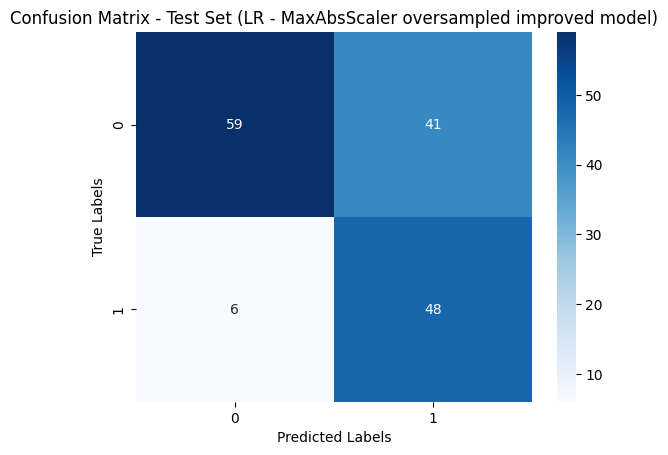

In [18]:
def show_best_model_metrics(best_model):
    """
    Show the best model scoring, optimized parameters and confusion matrix.
    
    Parameters:
    best_model (ModelDescription): the best model parameters
    """
    print("Best model:")
    print("* Name:", best_model.name)
    print("* Parameters:", best_model.parameters)

    evaluate_model(best_model.name, best_model.clf_model, best_model.X_test, best_model.y_test, show_conf_matrix=True)


def store_best_model(best_model):
    """
    Store the best model in a pickle file called as the best_model.name
    
    Parameters:
    best_model (ModelDescription): the best model parameters
    """
    filename = best_model.name + ".pkl"
    filename = filename.replace(" ", "")
    
    with open(filename, 'wb') as file:  
        pickle.dump(best_model.clf_model, file)


show_best_model_metrics(best_model)
store_best_model(best_model)